# Housing Price Prediction

### Description

Housing is one of the necessities of human life, and demand is increasing day
by day. It is now essential to predict house prices as accurately as possible.
The price is dependent on various factors while predicting. House prediction
is useful for not only buyers and sellers but also helps in maintaining the
economy of the region. The main aim of this project is to predict the sale
prices of residential houses in Ames, Iowa. For achieving our purpose, we are
using the dataset provided on Kaggle for training and testing purposes.

## 1. Exploratory Data Analysis

### 1.1 Loading python libraries

In [62]:
#importing all the libraries
#Some of the references are taken from books and open-souce materials 
from math import *

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns
from matplotlib import colors
from numpy.random import randn
from numpy.random import seed

from sklearn.ensemble import StackingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from scipy.stats import pearsonr
from lightgbm import LGBMRegressor

from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn import model_selection

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
np.random.seed(99)  #90 #95 #0


'''Ignore deprecation and future, and user warnings.'''
import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning) 
wrn.simplefilter('ignore')

### 1.2 Loading data and printing basic stats

In [63]:
#reading data from csv
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_t = train['SalePrice']
test_id = test['Id'].copy()

In [64]:
#shape of training data
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nShape of training data: ',train.shape,'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

#shape of testing data
print('\n\nShape of testing data: ',test.shape,'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Shape of training data:  (1460, 81) 


"""""""""""""""""""""""""""""""""""""""


Shape of testing data:  (1459, 80) 


"""""""""""""""""""""""""""""""""""""""


In [65]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 1.3 Plotting few graphs to get better understanding of the data

"""""""""""""""""""""""""""""""""""""""


Distribution of sales price: 


"""""""""""""""""""""""""""""""""""""""


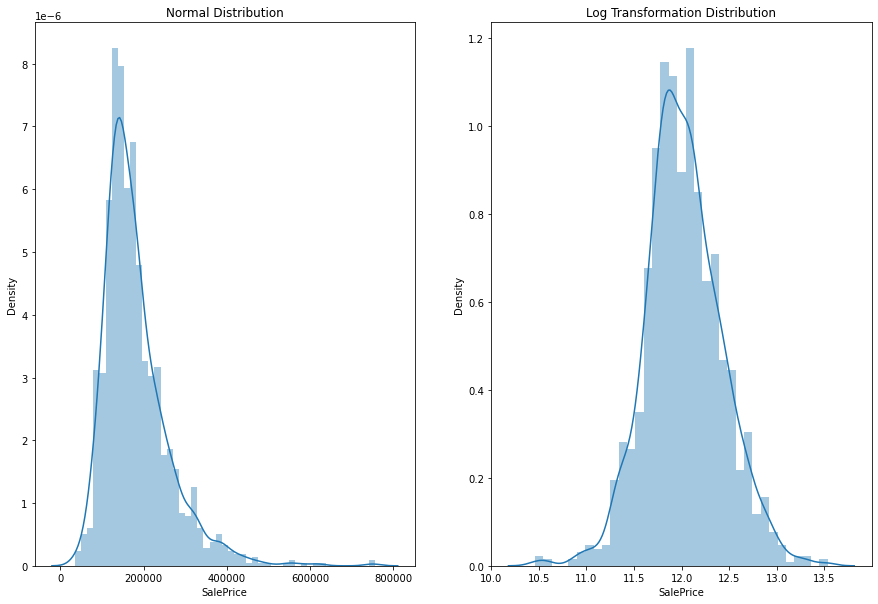

In [66]:
#Histogram Plot 
print('"""""""""""""""""""""""""""""""""""""""')
print("\n\nDistribution of sales price: \n\n")
_, (ax1, ax2) = plt.subplots(figsize=(15,10), ncols=2)
sns.distplot(train['SalePrice'], ax=ax1).set_title('Normal Distribution')
sns.distplot(np.log(train['SalePrice']), ax=ax2).set_title('Log Transformation Distribution')
print('"""""""""""""""""""""""""""""""""""""""')

__Observations__
- From the graph we can see normal distribution has skewness towards left.
- While taking its log we eliminated that skewness, so from now on we will only use log transformation of slaes price.

In [67]:
# Merging both train and test data to plot few graphs thus specified new columns to distinguish them 

train['diff']  = 1
test['diff']  = 0
df = pd.concat([train, test], axis=0,sort=False)

"""""""""""""""""""""""""""""""""""""""


Plotting Categorical columns


"""""""""""""""""""""""""""""""""""""""


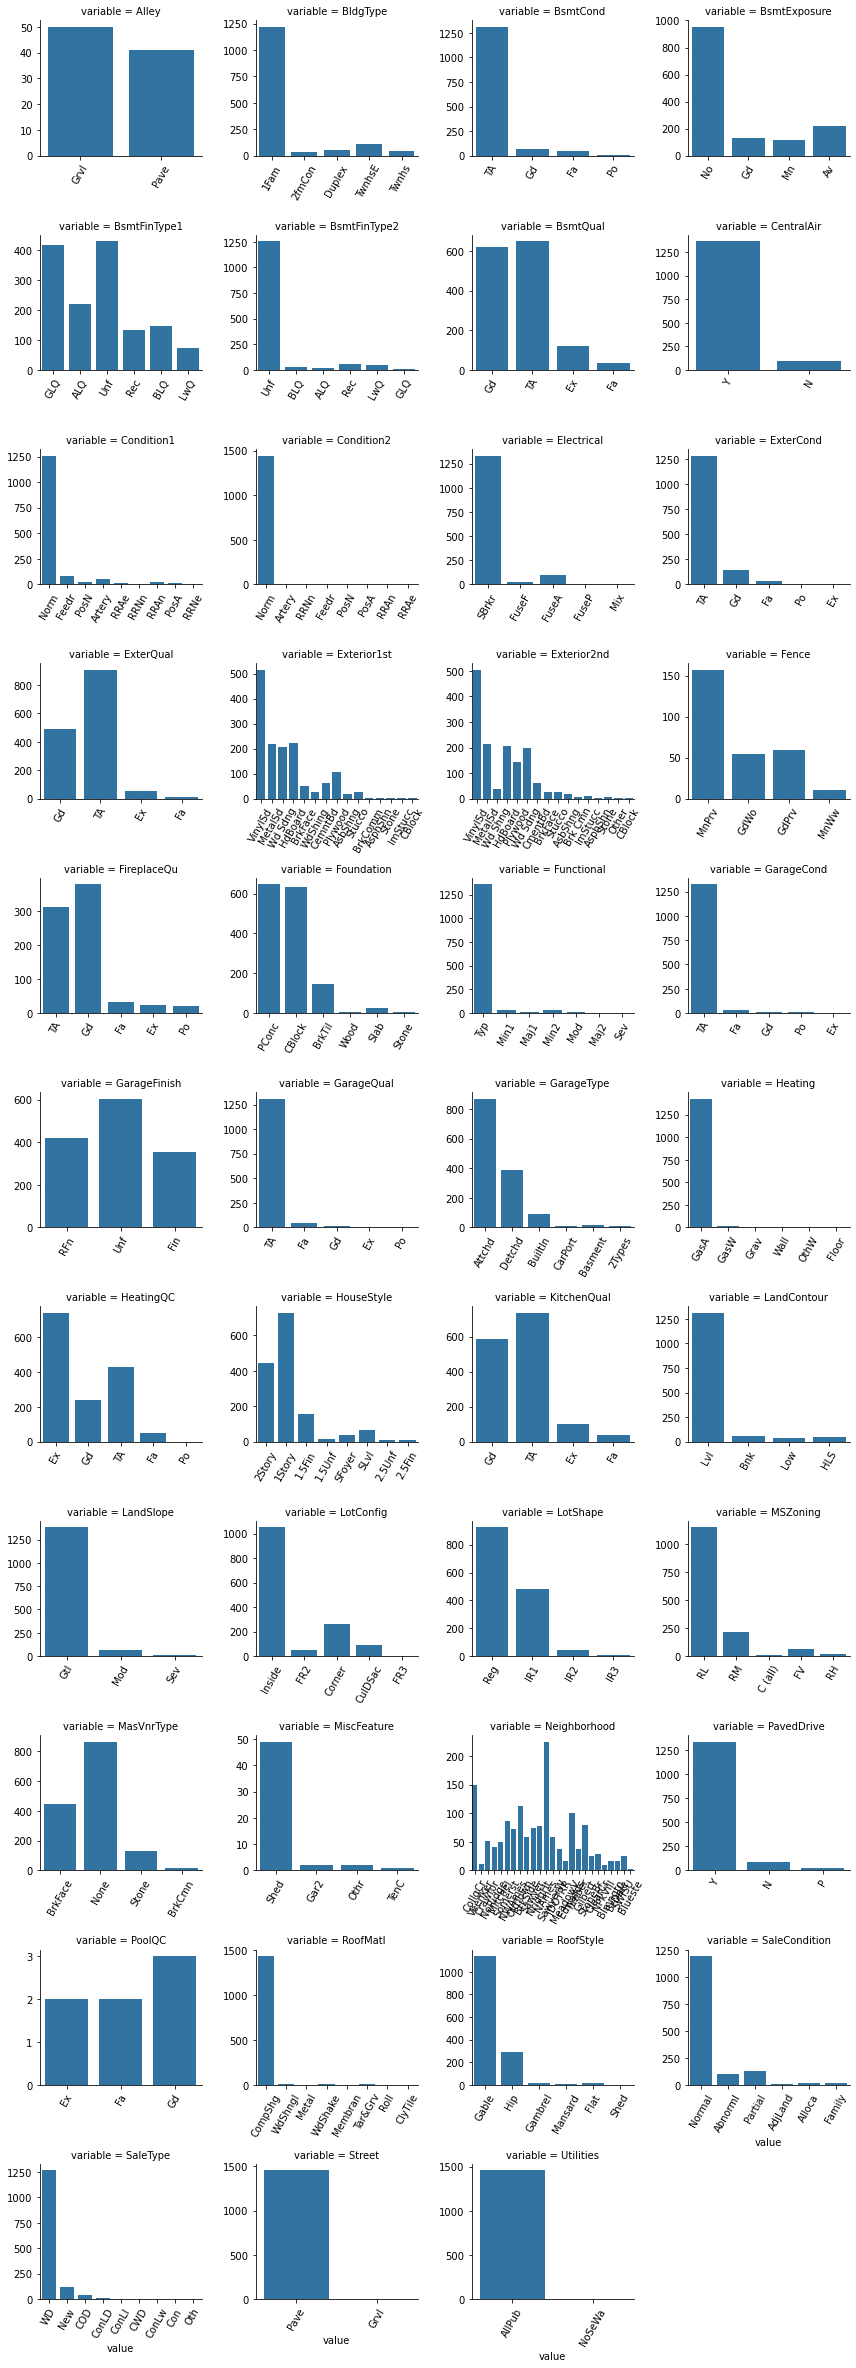

In [68]:
# Count plots of categorical features

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nPlotting Categorical columns\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

cat = df.select_dtypes(exclude = ['int64', 'float64'])
f = pd.melt(train, value_vars=sorted(cat))

g = sns.FacetGrid(f, col='variable', col_wrap=4, sharex=False, sharey=False,palette='RdBu')
plt.xticks(rotation='vertical')

g = g.map(sns.countplot, 'value')
[plt.setp(ax.get_xticklabels(), rotation=60) for ax in g.axes.flat]

g.fig.tight_layout()
plt.show()

### 1.4 Checking if question_text contains any null or duplicate values

In [69]:
#count of null values
null_columns = df.isnull().sum()
null_columns.sort_values(ascending=False, inplace= True)

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nNumber of null columns according to values:\n\n',null_columns, '\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Number of null columns according to values:

 PoolQC          2909
MiscFeature     2814
Alley           2721
Fence           2348
SalePrice       1459
                ... 
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
diff               0
Length: 82, dtype: int64 


"""""""""""""""""""""""""""""""""""""""


In [70]:
# we have total values and number of missing values thus we can get their percentage 

miss_per = df.isna().mean().round(4) * 100
miss_per.sort_values(ascending=False, inplace=True)
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nMissing Percentage:\n\n',miss_per, '\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Missing Percentage:

 PoolQC          99.66
MiscFeature     96.40
Alley           93.22
Fence           80.44
SalePrice       49.98
                ...  
1stFlrSF         0.00
2ndFlrSF         0.00
LowQualFinSF     0.00
GrLivArea        0.00
diff             0.00
Length: 82, dtype: float64 


"""""""""""""""""""""""""""""""""""""""


In [71]:
#function to plot missing percentage
def missing_percentage(df1, width=18, height=10, color=('silver', 'gold','lightgreen','skyblue','lightpink'), edgecolor='black'):
    fig, ax = plt.subplots(figsize=(width, height))

    null_val = (df1.isnull().sum() / len(df1))*100
    tight= 0.008*max(null_val)
    
    null_val = null_val.drop(null_val[null_val == 0].index).sort_values().reset_index()
    mn= ax.barh(null_val.iloc[:,0], null_val.iloc[:,1], color=color, edgecolor=edgecolor)
    
    ax.set_title('Missing values percentage', fontsize=15, weight='bold' )
    ax.set_xlabel('Percentage', weight='bold', size=15)
    ax.set_ylabel('Features with missing values', weight='bold')
    plt.yticks(weight='bold')
    plt.xticks(weight='bold')
    
    for i in ax.patches:
        ax.text(i.get_width()+ tight, i.get_y()+0.1, str(round((i.get_width()), 2))+'%',
            fontsize=10, fontweight='bold', color='grey')
    return plt.show()

"""""""""""""""""""""""""""""""""""""""


Plotting Missing Percentage


"""""""""""""""""""""""""""""""""""""""


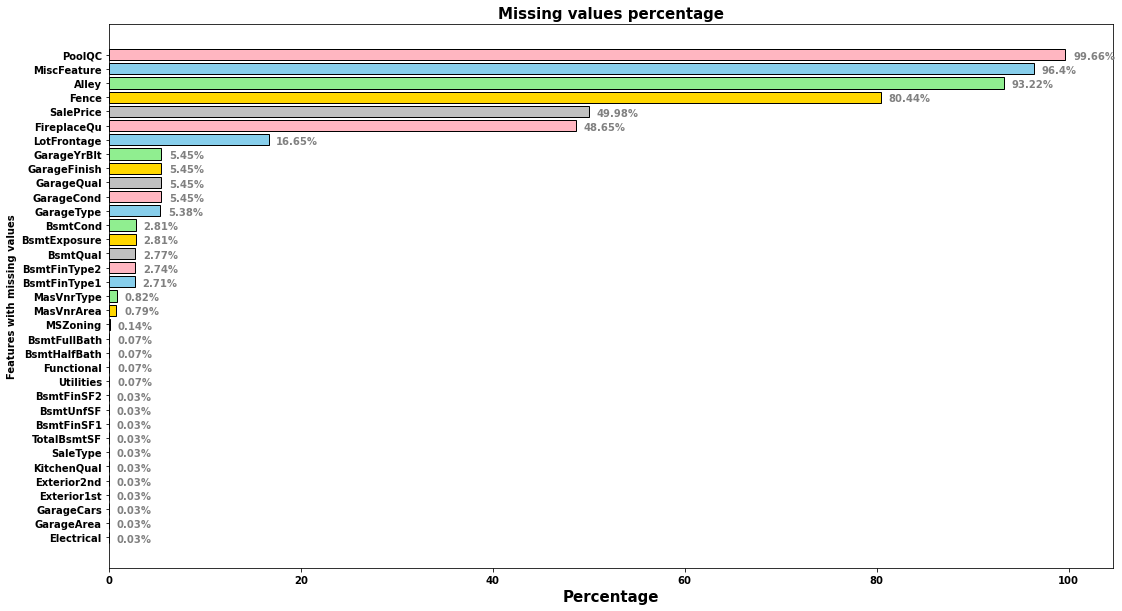

In [72]:
#plotting missing percentage
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nPlotting Missing Percentage\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

missing_percentage(df)

In [73]:
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n Deleteing all the features with missing percentage greater than 80% \n\n');
print(miss_per[miss_per>80.00],'\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

df = df.drop(['PoolQC','MiscFeature','Alley','Fence'],axis=1)

"""""""""""""""""""""""""""""""""""""""


 Deleteing all the features with missing percentage greater than 80% 


PoolQC         99.66
MiscFeature    96.40
Alley          93.22
Fence          80.44
dtype: float64 


"""""""""""""""""""""""""""""""""""""""


Reason for dropping those column was because we don't have too much time to fill those data manually nor we can generalize those data from which we have since it is too little. 

In [74]:
#corelation of sale price with every other parameters

correlation = df.corr()
columns = correlation['SalePrice'].sort_values(ascending=False).to_frame()
cm = sns.light_palette('green',as_cmap=True)
c1 = columns.style.background_gradient(cm)

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nPlotting Correlation values\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

c1

"""""""""""""""""""""""""""""""""""""""


Plotting Correlation values


"""""""""""""""""""""""""""""""""""""""


,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


"""""""""""""""""""""""""""""""""""""""


Plotting Heat Map


"""""""""""""""""""""""""""""""""""""""


<AxesSubplot:>

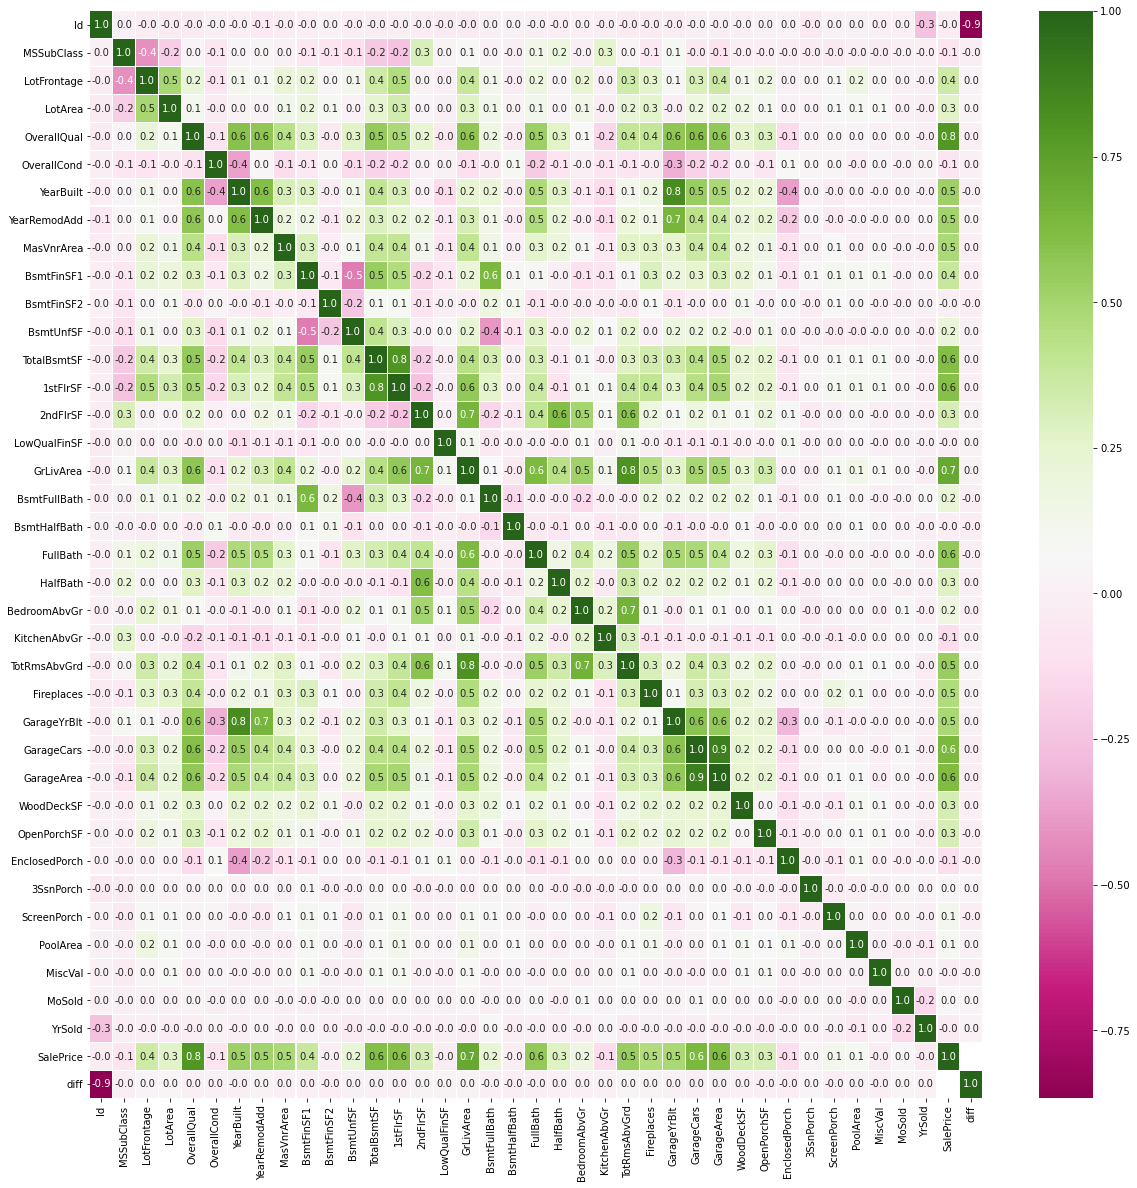

In [75]:
#heatplot
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nPlotting Heat Map\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df.corr(),annot=True, linewidths=.1, fmt= '.1f',ax=ax, cmap="PiYG")

## 2. Preprocessing

In [76]:
#dropping non correlated values

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nDropping not related columns\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

df = df.drop(['Heating','RoofMatl','Condition2','Street'],axis=1)

"""""""""""""""""""""""""""""""""""""""


Dropping not related columns


"""""""""""""""""""""""""""""""""""""""


In [77]:
print(df['FireplaceQu'].value_counts())

Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: FireplaceQu, dtype: int64


In [78]:
# We can guess that if there is null in fireplace then there are no fireplace available at the property
# So we can change those to "None"

df.loc[df['FireplaceQu'].isnull(),'FireplaceQu'] = 'None'

In [79]:
#Crosstab between FirePlaces ad FirePlace Quality

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nCross Tab between Fireplaces and Fireplace Quality:\n')
print(pd.crosstab(df.Fireplaces, df.FireplaceQu))
print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


Cross Tab between Fireplaces and Fireplace Quality:

FireplaceQu  Ex  Fa   Gd  None  Po   TA
Fireplaces                             
0             0   0    0  1420   0    0
1            37  63  627     0  46  495
2             5  10  112     0   0   92
3             1   1    5     0   0    4
4             0   0    0     0   0    1
"""""""""""""""""""""""""""""""""""""""


In [80]:
# Relationship between LotFrontage and LotArea

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 1) Correlation between LotFrontage and LotArea:\t',df['LotFrontage'].corr(np.sqrt(df['LotArea'])),'\n\n')

# Value is above 50% so we can find LotFrontage with the help of sqrt LotArea, for all the null values in LotFrontage 

df.LotFrontage[df['LotFrontage'].isnull()]=np.sqrt(df.LotArea[df['LotFrontage'].isnull()])


# Handling null values for all garage related columns

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 2) Handling null values for Garage Columns\n\n')

garage_cols=['GarageType','GarageQual','GarageCond','GarageYrBlt','GarageFinish','GarageCars','GarageArea']
df[garage_cols][df['GarageType'].isnull()==True]

for cols in garage_cols:
    if df[cols].dtype==np.object:
        df.loc[df[cols].isnull(),cols] = 'None' # it it is np.object type then change null value to 'none'
    else:
        df.loc[df[cols].isnull(),cols] = 0 # if they are int or float then change them to 0
        
# Handling null values for all Basement columns at once

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 3) Handling null values for Basement Columns\n\n')


bsmt_cols = ['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']
df[bsmt_cols][df['BsmtExposure'].isnull()==True]

for cols in bsmt_cols:
    if df[cols].dtype==np.object:
        df.loc[df[cols].isnull(),cols] = 'None' # it it is np.object type then change null value to 'none'
    else:
        df.loc[df[cols].isnull(),cols] = 0 # if they are int or float then change them to 0
        
# Handling null values for all MasVnr

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 4) Handling null values for MasVnr Columns\n\n')


df['MasVnrType'].fillna('None',inplace=True)
df['MasVnrArea'].fillna(0,inplace=True)

#filling null with most frequent values

df['MSZoning'].fillna(df.MSZoning.mode()[0],inplace=True)

#Combining all the bathroom 

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 5) Now Handling Bathroom Columns\n\n')


df['TotalBathroom'] = df['BsmtFullBath'] + 0.5*df['BsmtHalfBath'] + df['FullBath'] + 0.5*df['HalfBath']

df.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'],axis=1,inplace=True)

df['TotalBathroom'].fillna(df['TotalBathroom'].mode()[0],inplace=True)

#Utilities management

print('"""""""""""""""""""""""""""""""""""""""')

print('\n\n 6) All values are same in Utilities so removing the column\n\n')
df.drop(['Utilities'],axis=1,inplace=True)

print('"""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""


 1) Correlation between LotFrontage and LotArea:	 0.6476580398617829 


"""""""""""""""""""""""""""""""""""""""


 2) Handling null values for Garage Columns


"""""""""""""""""""""""""""""""""""""""


 3) Handling null values for Basement Columns


"""""""""""""""""""""""""""""""""""""""


 4) Handling null values for MasVnr Columns


"""""""""""""""""""""""""""""""""""""""


 5) Now Handling Bathroom Columns


"""""""""""""""""""""""""""""""""""""""


 6) All values are same in Utilities so removing the column


"""""""""""""""""""""""""""""""""""""""


In [81]:
# Handling functional

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 1) Now Handling Functional Column\n\n')

df['Functional'].fillna(df.Functional.mode()[0],inplace=True)

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 2) Now Handling All Left Columns\n\n')

left_out = ['Exterior2nd','Exterior1st','TotalBsmtSF','Electrical','SaleType','BsmtFinSF1','BsmtUnfSF','KitchenQual']
for cols in left_out:
    if df[cols].dtype==np.object:
        temp = df[cols].mode()
        df.loc[df[cols].isnull(),cols] = temp.iloc[0]
    else:
        df.loc[df[cols].isnull(),cols] = df[cols].mean()
        
#Convert few date columns

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 3) Converting some columns to more appropriate formate \n\n')

df['YB'] = pd.to_datetime(df['YearBuilt'], format='%Y', errors='ignore').dt.year
df['YR'] = pd.to_datetime(df['YearRemodAdd'], format='%Y', errors='ignore').dt.year
df['YS'] = pd.to_datetime(df['YrSold'], format='%Y', errors='ignore').dt.year
df['GYB'] = pd.to_datetime(df['YrSold'], format='%Y', errors='ignore').dt.year

# Construct new variables for years since - Take the difference between the current year and variable year
df["House_age"] = datetime.datetime.now().year - df['YB']  
df["Last_Reno"] = datetime.datetime.now().year- df['YR']  
df["Sold_Age"] = datetime.datetime.now().year - df['YS']  
df["Garage_Age"] = datetime.datetime.now().year - df['GYB'] 
# Delete old columns
print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nAdded new Columns and Removing old columns \n\n')

df.drop(['YearBuilt', 'YearRemodAdd', 'YrSold', 'GarageYrBlt'], axis=1,inplace=True)

#Handling left null values

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 4) Handling null values for left out columns \n\n')

left_out = ['Exterior2nd','Exterior1st','TotalBsmtSF','Electrical','SaleType','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','Functional']
for cols in left_out:
    if df[cols].dtype==np.object:
        df.loc[df[cols].isnull(),cols] = df[cols].mode()[0]
    else:
        df.loc[df[cols].isnull(),cols] = df[cols].mean()

#using label encoding to convert categorical values

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\n 5) Using Label Encoding to convert all the categorical values.\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

cat=[x for x in df.columns if df[x].dtype=="object"]
le=LabelEncoder()
for col in cat:
    if col in df.columns:
        i = df.columns.get_loc(col)
        df.iloc[:,i] = df.apply(lambda i:le.fit_transform(i.astype(str)), axis=0, result_type='expand')

"""""""""""""""""""""""""""""""""""""""


 1) Now Handling Functional Column


"""""""""""""""""""""""""""""""""""""""


 2) Now Handling All Left Columns


"""""""""""""""""""""""""""""""""""""""


 3) Converting some columns to more appropriate formate 


"""""""""""""""""""""""""""""""""""""""


Added new Columns and Removing old columns 


"""""""""""""""""""""""""""""""""""""""


 4) Handling null values for left out columns 


"""""""""""""""""""""""""""""""""""""""


 5) Using Label Encoding to convert all the categorical values.


"""""""""""""""""""""""""""""""""""""""


In [82]:
#Preprocessing over ow separating test and train 

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nEDA and Pre-Processing finishes here.\n\n')

print('"""""""""""""""""""""""""""""""""""""""')
df1, df2 = [x for _, x in df.groupby(df['diff'] == 0)]

"""""""""""""""""""""""""""""""""""""""


EDA and Pre-Processing finishes here.


"""""""""""""""""""""""""""""""""""""""


In [83]:
#train and test set
train = df1.copy()
test = df2.copy()

#removing the separate label
train.drop('diff',axis = 1, inplace=True)
test.drop('diff',axis = 1, inplace=True)

In [84]:
#taking log transformation of sale price

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nFrom the distribution, we have seen that log tranformation of sale price is not skewed. So using the log transformation of Sale Price\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

y_train = np.log(train['SalePrice'])
train.drop(['SalePrice'],axis=1,inplace=True)
test.drop(['SalePrice'],axis=1,inplace=True)

"""""""""""""""""""""""""""""""""""""""


From the distribution, we have seen that log tranformation of sale price is not skewed. So using the log transformation of Sale Price


"""""""""""""""""""""""""""""""""""""""


In [85]:
#Train and Cross-validation set 

print('"""""""""""""""""""""""""""""""""""""""')
print('\n\nTrain and test. First 70% for train and next 30% for test without shuffle (Mentioned in assignment task)\n\n')
print('"""""""""""""""""""""""""""""""""""""""')

X_train,X_test,y_train,y_test = train_test_split(train,y_train,test_size=0.3, shuffle=False)

"""""""""""""""""""""""""""""""""""""""


Train and test. First 70% for train and next 30% for test without shuffle (Mentioned in assignment task)


"""""""""""""""""""""""""""""""""""""""


In [86]:
#Linear Regression
lr = LinearRegression()
lr.fit(X_train,y_train)
y_predict1 = lr.predict(X_test)

print(' Root Mean Square Error in Linear Regression: ',sqrt(mean_squared_error(y_test,y_predict1)))

r2 = r2_score(y_test,y_predict1)
print('\nR2 Score in Linear Regression: ',r2)


 Root Mean Square Error in Linear Regression:  0.17863656021200564

R2 Score in Linear Regression:  0.7853684371046676


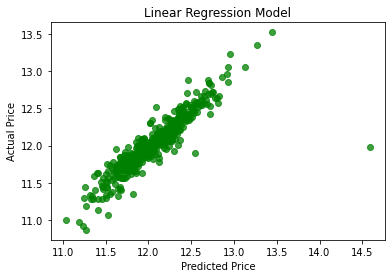

In [89]:
#Predicted vs Actual Graph using CV Data for Linear Regression

actual_values = y_test
plt.scatter(y_predict1, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [91]:
#Lasso Regression with CV to select best alpha automatically

la = LassoCV()
la.fit(X_train,y_train)
y_predict2 = la.predict(X_test)
print(' Root Mean Square Error in Lasso Regression: ',sqrt(mean_squared_error(y_test,y_predict2)))

r2_2 = r2_score(y_test,y_predict2)
print('\nR2 Score in Lasso Regression: ',r2_2)


 Root Mean Square Error in Lasso Regression:  0.2413974665108203

R2 Score in Lasso Regression:  0.6080611547629006


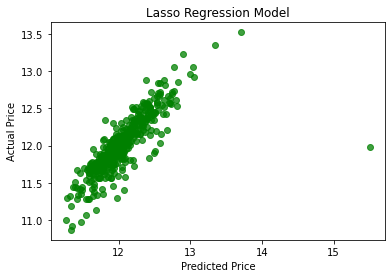

In [90]:
#Predicted vs Actual Graph using CV Data for Lasso Regression

actual_values = y_test
plt.scatter(y_predict2, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Lasso Regression Model')
plt.show()

In [92]:
#Ridge Regression with CV to select best alpha automtically
ri = RidgeCV()
ri.fit(X_train,y_train)
y_predict3 = ri.predict(X_test)
print(' Root Mean Square Error in Ridge Regression: ',sqrt(mean_squared_error(y_test,y_predict3)))

r2_3 = r2_score(y_test,y_predict3)
print('\nR2 Score in Ridge Regression: ',r2_3)


 Root Mean Square Error in Ridge Regression:  0.178659841078898

R2 Score in Ridge Regression:  0.7853124896049387


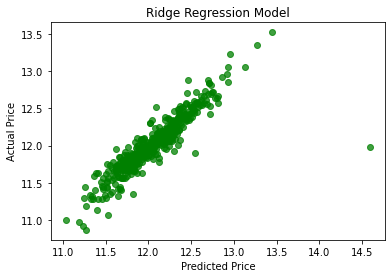

In [93]:
#Predicted vs Actual Graph using CV Data for Ridge Regression

actual_values = y_test
plt.scatter(y_predict3, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regression Model')
plt.show()

In [95]:
#Elastic net: Ridge + Lasso Regression

e_net = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
e_net.fit(X_train,y_train)
y_predict4 = e_net.predict(X_test)
print(' Root Mean Square Error in ElasticNet Regression: ',sqrt(mean_squared_error(y_test,y_predict4)))

r2_4 = r2_score(y_test,y_predict4)
print('\nR2 Score in ElasticNet Regression: ',r2_4)


 Root Mean Square Error in ElasticNet Regression:  0.17907182131063704

R2 Score in ElasticNet Regression:  0.7843212317281283


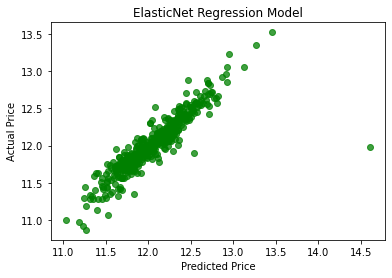

In [96]:
#Predicted vs Actual Graph using CV Data for ElasticNet Regression

actual_values = y_test
plt.scatter(y_predict4, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('ElasticNet Regression Model')
plt.show()

In [98]:
#Gradient Boosting Algorithm 

gra = GradientBoostingRegressor(random_state=0)
gra.fit(X_train,y_train)
y_predict5 = gra.predict(X_test)
print(' Root Mean Square Error in Gradient Boosting: ',sqrt(mean_squared_error(y_test,y_predict5)))

r2_5 = r2_score(y_test,y_predict5)
print('\nR2 Score in Gradient Boosting: ',r2_5)


 Root Mean Square Error in Gradient Boosting:  0.12997148974034187

R2 Score in Gradient Boosting:  0.8863814907275043


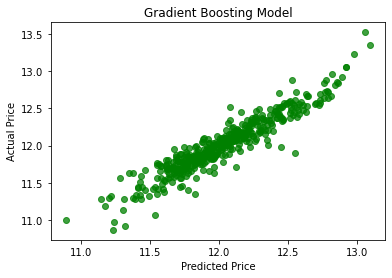

In [99]:
#Predicted vs Actual Graph using CV Data for Gradient Boosting

actual_values = y_test
plt.scatter(y_predict5, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Gradient Boosting Model')
plt.show()

In [100]:
#XGB Regressor with default values
xgb =XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)

#LGBM Regressor with default values
lgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )

In [102]:
#XGB

xgb.fit(X_train,y_train)
y_predict6 = xgb.predict(X_test)

print('\n Root Mean Square Error in XGB: ',sqrt(mean_squared_error(y_cv,y_predict6)))

r2_6 = r2_score(y_cv,y_predict6)
print('\nR2 Score in XGB: ',r2_6)


[11:51:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.

 Root Mean Square Error in XGB:  0.13331295950345398

R2 Score in XGB:  0.8804642990583451


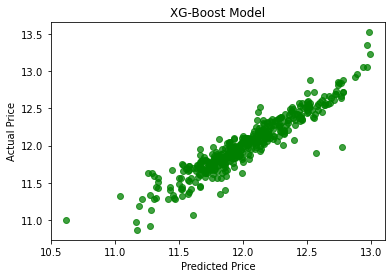

In [103]:
#Predicted vs Actual Graph using CV Data for XG-Boost

actual_values = y_test
plt.scatter(y_predict6, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XG-Boost Model')
plt.show()

In [105]:
#LGBM fitting

lgbm.fit(X_train,y_train)
y_predict7 = lgbm.predict(X_test)

print('\n Root Mean Square Error in LGBM: ',sqrt(mean_squared_error(y_cv,y_predict7)))

r2_7 = r2_score(y_cv,y_predict7)
print('\nR2 Score in LGBM: ',r2_7)


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5

 Root Mean Square Error in LGBM:  0.1384316583763594

R2 Score in LGBM:  0.8711086607041029


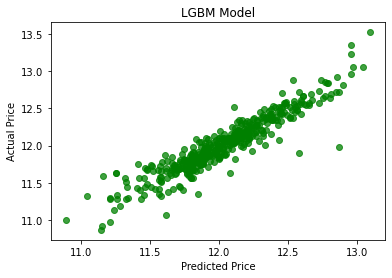

In [106]:
#Predicted vs Actual Graph using CV Data for LGBM

actual_values = y_test
plt.scatter(y_predict7, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('LGBM Model')
plt.show()

In [107]:
#Combining all the different regression models using stacked regression
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\n Using Stacked Regression: Combining all the seven different regression: ')
estimators = [
    ('lr', LinearRegression()),
    ('la', LassoCV()),
    ('Ri',RidgeCV()),
    ('e_net',ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)),
    ('lgbm',LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=12000, 
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.4, 
                                       )) 
]
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


 Using Stacked Regression: Combining all the seven different regression: 
"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""


In [108]:
#Stack Regression
reg = StackingRegressor(
     estimators=estimators,
    final_estimator=XGBRegressor( booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=4, min_child_weight=1.5, n_estimators=2400,
             n_jobs=1, nthread=None, objective='reg:linear',
             reg_alpha=0.6, reg_lambda=0.6, scale_pos_weight=1, 
             silent=None, subsample=0.8, verbosity=1)
)

In [111]:
print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')
print('\n\n Score for Stacked Regression: ',reg.fit(X_train, y_train).score(X_test, y_test),'\n\n')


final_predict = reg.predict(X_test)
print('\n Root Mean Square Error Stacked CV: ',sqrt(mean_squared_error(y_cv,final_predict)))

print('"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""')

"""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""""
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fra

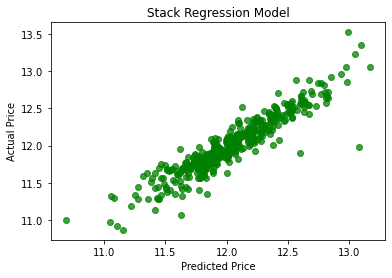

In [112]:
#Predicted vs Actual Graph using CV Data for Stack-Regression 

actual_values = y_test
plt.scatter(final_predict, actual_values, alpha=.75,color='g') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Stack Regression Model')
plt.show()

In [114]:
print('Applying model on test file ')
predict_test = reg.predict(test)

predict_test

Applying model on test file 


array([11.793593, 12.002793, 12.148147, ..., 12.075774, 11.711267,
       12.393887], dtype=float32)

These values are in log formate since we transformed our sales predictions into log

In [115]:
predict_test = np.exp(predict_test)

predict_test

array([132401.39, 163210.05, 188743.95, ..., 175566.69, 121937.94,
       241321.8 ], dtype=float32)